In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os, sys

import batman

%matplotlib inline

In [2]:
def transit_model(time, t0, per, rp, a, inc, ecc, w, u1, u2):
    params = batman.TransitParams()                      #object to store transit parameters
    params.t0 = t0                                       #time of inferior conjunction
    params.per = per                                     #orbital period
    params.rp = rp                                       #planet radius (in units of stellar radii)
    params.a = a                                         #semi-major axis (in units of stellar radii)
    params.inc = inc                                     #orbital inclination (in degrees)
    params.ecc = ecc                                     #eccentricity
    params.w = w                                         #longitude of periastron (in degrees)
    params.limb_dark = "quadratic"                       #limb darkening model
    params.u = [u1, u2]                                  #limb darkening coefficients

    m    = batman.TransitModel(params, time)             #initializes model
    flux = m.light_curve(params)                         # get flux as a function of time
    t_secondary = m.get_t_secondary(params)              # get time of secondary eclipse
    anom       = m.get_true_anomaly()                    # get true anomaly for each point in time
    return flux, t_secondary, anom

def eclipse(time, t0, per, rp, a, inc, ecc, w, u1, u2, fp, t_sec):
    params = batman.TransitParams()                      #object to store transit parameters
    params.t0 = t0                                       #time of inferior conjunction
    params.per = per                                     #orbital period
    params.rp = rp                                       #planet radius (in units of stellar radii)
    params.a = a                                         #semi-major axis (in units of stellar radii)
    params.inc = inc                                     #orbital inclination (in degrees)
    params.ecc = ecc                                     #eccentricity
    params.w = w                                         #longitude of periastron (in degrees)
    params.limb_dark = "quadratic"                       #limb darkening model
    params.u = [u1, u2]                                  #limb darkening coefficients
    params.fp = fp                                       #planet/star brightnes
    params.t_secondary = t_sec
    
    m    = batman.TransitModel(params, time, transittype="secondary")  #initializes model
    flux = m.light_curve(params)
    return flux

def phase_variation_ecc(anom, w, A, B, C, D):
    # get orbital phase
    phi  = anom + w + np.pi/2
    # get phase variation
    phase = 1 + A*(np.cos(phi)-1) + B*np.sin(phi) + C*(np.cos(2*phi)-1) + D*np.sin(2*phi)
    return phase

def phase_variation_circ(time, t_sec, per, A, B, C, D):
    # orbital phase
    t    = time - t_sec
    freq = 2*np.pi/per
    phi  = (freq*t)
    # phase variation or flux at each orbital phase
    phase = 1 + A*(np.cos(phi)-1) + B*np.sin(phi) + C*(np.cos(2*phi)-1) + D*np.sin(2*phi)
    return phase

def fplanet_model(eclip, phase):
    return phase*(eclip - 1)

def binning_data(data, size):
    '''
    Median bin an array.

    Parameters
    ----------
    data     : 1D array
        Array of data to be binned.

    size     : int
        Size of bins.

    Returns
    -------
    binned_data: 1D array
        Array of binned data.

    binned_data: 1D array
        Array of standard deviation for each entry in binned_data.
    '''
    data = np.ma.masked_invalid(data) 
    reshaped_data   = data.reshape((int(len(data)/size), size))
    binned_data     = np.ma.median(reshaped_data, axis=1)
    binned_data_std = np.std(reshaped_data, axis=1)
    return binned_data

# Phase Curve Example

In [55]:
# Some definition for CoRoT-2b at 4.5 micron

t0   = 1.0744                                # BMJD time
per  = 1.74                                  # in days
rp   = 0.1696                                # radius (in solar radius)/stellar radius (solar radius) 
a    = 6.679               # 
inc  = 87.8684                                 # 90 = edge-on                
ecc  = 0.0279
w    = 102
u1  = 2*np.sqrt(0.0133)*0.2957
u2  = np.sqrt(0.0133)*(1-2*0.2957)
fp   = 0.0044                                 # eclipse depth in units of stellar flux
    
A    = 0.4443
B    = 0.1634
C    = 0.0669
D    = 0.0081

In [56]:
time = np.linspace(t0-per/2+(-2.3/2-4)/24, t0+per/2+(2.3/2+4)/24,1000)

# get transit signal (or stellar flux)
trans, t_sec, anom  = transit_model(time, t0, per, rp, a, inc, ecc, w, u1, u2)
# get secondary eclipse signal
eclip               = eclipse(time, t0, per, rp, a, inc, ecc, w, u1, u2, fp, t_sec)
# get phase variations scaled as the secondary eclipse depth
phase               = phase_variation_ecc(anom, w, A, B, C, D)

# get the flux from the planet
fplanet = fplanet_model(eclip, phase)

# total flux = star + planet
phase_curve45 = trans + fplanet

time_bin      = binning_data(time, 20)
phase_bin45   = binning_data(phase_curve45, 20)

# make noise
noise45 = np.random.normal(0, 0.00146/np.sqrt(20), len(phase_bin45))

# data
data45 = phase_bin45 + noise45

In [57]:
# Some definition for CoRoT-2b at 4.5 micron

t0   = 1.0744                                # BMJD time
per  = 1.74                                  # in days
rp   = 0.1696                                # radius (in solar radius)/stellar radius (solar radius) 
a    = 6.679               # 
inc  = 87.8684                                 # 90 = edge-on                
ecc  = 0.0279
w    = 102
u1  = 2*np.sqrt(0.0133)*0.2957
u2  = np.sqrt(0.0133)*(1-2*0.2957)
fp   = 0.00355                                 # eclipse depth in units of stellar flux
    
A    = 0.4443
B    = 0.1634
C    = 0.0669
D    = 0.0081



In [58]:
# get transit signal (or stellar flux)
trans, t_sec, anom  = transit_model(time, t0, per, rp, a, inc, ecc, w, u1, u2)
# get secondary eclipse signal
eclip               = eclipse(time, t0, per, rp, a, inc, ecc, w, u1, u2, fp, t_sec)
# get phase variations scaled as the secondary eclipse depth
phase               = phase_variation_ecc(anom, w, A, B, C, D)

# get the flux from the planet
fplanet = fplanet_model(eclip, phase)

# total flux = star + planet
phase_curve36 = trans + fplanet

time_bin      = binning_data(time, 20)
phase_bin36   = binning_data(phase_curve36, 20)

# make noise
noise36 = np.random.normal(0, 0.0015/np.sqrt(20), len(phase_bin36))

# data
data36 = phase_bin36 + noise36

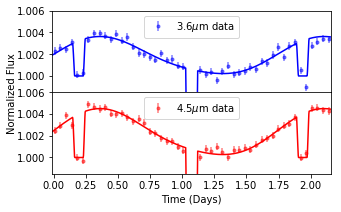

In [59]:
fig, axes = plt.subplots(ncols=1, nrows =2, sharex=True, sharey=True, figsize=(5,3))

axes[0].plot(time, phase_curve36, color='b')
axes[0].errorbar(time_bin, data36, yerr= 0.0015/np.sqrt(20), fmt='o', markersize = 3, alpha = 0.5, color='b', label='3.6$\mu$m data')

axes[1].plot(time, phase_curve45, color='r')
axes[1].errorbar(time_bin, data45, yerr=0.00146/np.sqrt(20), fmt='o', markersize = 3, alpha = 0.5, color='r', label='4.5$\mu$m data')

axes[0].set_ylim(0.9985, 1.006)
axes[1].set_ylim(0.9985,1.006)

axes[0].legend(loc=9)
axes[1].legend(loc=9)

axes[0].set_xlim(np.min(time), np.max(time))

axes[1].set_xlabel('Time (Days)')
fig.text(0.0, 0.5, 'Normalized Flux', va='center', rotation='vertical')
#fig.ylabel('Normalized flux')
#axes[1].set_ylabel('Normalized flux')
#axes[0].set_ylabel('Normalized flux')

fig.subplots_adjust(hspace=0)
fig.savefig('CoRoT-2b_ww.pdf', bbox='tight')

# Figure 2

ValueError: x and y must have same first dimension, but have shapes (1000,) and (50,)

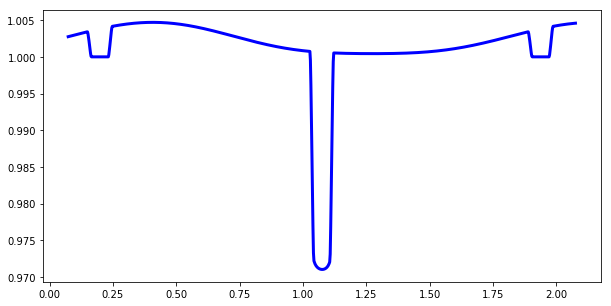

In [121]:
plt.figure(figsize = (10,5))
plt.plot(time, phase_curve45, linewidth=3, color='b')
plt.plot(time, data45, 'o', markersize = 2, alpha = 0.5, color='b')

plt.plot(time, phase_curve36, color='r')
plt.plot(time_bin, data36, 'o', markersize = 5, alpha = 0.5, color='r')
plt.ylim(0.995,1.010)
plt.xlabel('Time (BMJD)')
plt.ylabel('Normalized flux')

Text(0,0.5,'Normalized flux')

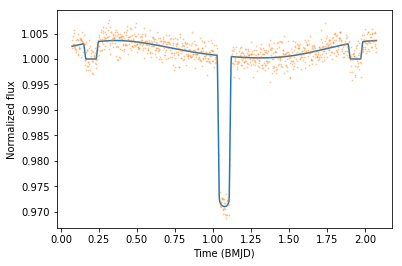

In [33]:
plt.figure()

plt.plot(time, phase_curve36)
plt.plot(time, data36, '.', markersize = 2, alpha = 0.3)

plt.xlabel('Time (BMJD)')
plt.ylabel('Normalized flux')

In [227]:
batman.__version__

'2.4.6'

In [243]:
time_bin[1]-time_bin[0]

0.04342676009342676

In [245]:
20*(time[1]-time[0])*24

1.0422422422422422

In [237]:
filename = np.array(['CoRoT-2_ww.pdf', 'CoRoT-2_ew.pdf', 'CoRoT-2_we.pdf', 'CoRoT-2_ee.pdf'])

t0   = 1.0744                                # BMJD time
per  = 1.74                                  # in days
rp   = 0.1696                                # radius (in solar radius)/stellar radius (solar radius) 
a    = 6.679                                 # 
inc  = 87.8684                               # 90 = edge-on                
ecc  = 0.0279
w    = 102
u1  = 2*np.sqrt(0.0133)*0.2957
u2  = np.sqrt(0.0133)*(1-2*0.2957)

time = np.linspace(t0-per/2+(-2.3/2-4)/24, t0+per/2+(2.3/2+4)/24,1000)

for i in range(4):
    '''4.5 micron light curve'''
    fp   = 0.0044
    if i==0:                                 
        A    = 0.4443
        B    = 0.1934
        C    = 0.0669
        D    = 0.0681
    if i==0:                               
        A    = 0.4443
        B    = 0.1934
        C    = 0.0669
        D    = 0.0681
    if i==0:                                
        A    = 0.2443
        B    = -0.2434
        C    = 0.0669
        D    = 0.0681
    if i==0:                                
        A    = 0.4443
        B    = 0.1934
        C    = 0.0669
        D    = 0.0681
        
    # get transit signal (or stellar flux)
    trans, t_sec, anom  = transit_model(time, t0, per, rp, a, inc, ecc, w, u1, u2)
    # get secondary eclipse signal
    eclip               = eclipse(time, t0, per, rp, a, inc, ecc, w, u1, u2, fp, t_sec)
    # get phase variations scaled as the secondary eclipse depth
    phase               = phase_variation_ecc(anom, w, A, B, C, D)

    # get the flux from the planet
    fplanet = fplanet_model(eclip, phase)

    # total flux = star + planet
    phase_curve45 = trans + fplanet

    time_bin      = binning_data(time, 20)
    phase_bin45   = binning_data(phase_curve45, 20)

    # make noise
    noise45 = np.random.normal(0, 0.00146/np.sqrt(20), len(phase_bin45))

    # data
    data45 = phase_bin45 + noise45
    
    if i==0:
        fp   = 0.00355                                  
        A    = 0.4443
        B    = 0.1934
        C    = 0.0669
        D    = 0.0681